In [82]:
# Initial imports
import os
import requests
import pandas as pd
#import alpaca_trade_api as tradeapi
#from dotenv import load_dotenv
from pycoingecko import CoinGeckoAPI
%matplotlib inline

cg = CoinGeckoAPI()

# Load .env environment variables
#load_dotenv()

# Set Alpaca API key and secret
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
#alpaca = tradeapi.REST(
#    alpaca_api_key,
#    alpaca_secret_key,
#    api_version="v2")

## Initialize some dictionary and lists
portfolio_dict={}  # portfolio dictionary init
portfolio_list=[]  # list of portfolio tickers init
social_dict={} # dictionary for social data init
equities_dict={} #dictionary for equities data init
equities_list=[]





def get_crypto_portfolio_data(data):
### Uses get_price from the sdk and returns data for the users portfolio
    data = cg.get_price(ids=data,vs_currencies='usd', include_market_cap='true', include_24hr_vol='true', include_24hr_change='true', include_last_updated_at='false')
    return data


def get_coin_by_id(data):
### returns information about the coin including social data
    data = cg.get_coin_by_id(id=data,localization='false',tickers='false',market_data='false')
    return data


def create_crypto_portfolio_df(ticker_list):
##returns a portfolio dataframe of from a list of tickers
    
    #iterate through the list that was passed 
    for ticker in ticker_list:
        
        #get the data from the api
        api_data=get_crypto_portfolio_data(ticker)
    
        #the coin name is the first key in the api return data. We need it.
        coin = list(api_data.keys())[0] 

        #add data to dictionary
        portfolio_dict[coin] = api_data[coin]

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(portfolio_dict, orient='index')

    #wrangle the data into a portfolio
    df.columns=['Price', 'Market Cap', '24h Volume', '24h Change']
    df['Market Cap'] = df['Market Cap'].astype('int64')
    #df['24h Volume '] = df['24h Volume '].astype('int32')
    df['24h Change'] = df['24h Change'].astype('float64').round(decimals=2)

    #store to csv
    df.to_csv('data_portfolio.csv')

    #return the dataframe
    return df


def get_social_df(tickers):
# accepts a list of tickers and returns social inco in a dataframe

    for ticker in tickers:
        data=get_coin_by_id(ticker)
        social_dict[data['id']] = data['community_data']

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(social_dict, orient='index')
    df.columns=['FB Likes', 'TWTR Follows', 'reddit posts 48h', 'reddit comments 48h','reddit subscribes 48h','reddit active 48h','telegram users']
    
    df.to_csv('data_social.csv')    
    #return the dataframe
    return df



def get_equities_df(data):

    # Format current date as ISO format
    today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

    # Set timeframe to one day ('1D') for the Alpaca API
    timeframe = "1D"

    # Get current closing prices for FB and TWTR
    df_portfolio = alpaca.get_barset(
        tickers,
        timeframe,
        start = today,
        end = today
    ).df

    # Display sample data
    df_portfolio



def get_crypt_5yr_history(ticker_list):
    history_dfs = []

    for ticker in ticker_list:
        
        #Get the 5 year history 
        history = cg.get_coin_market_chart_range_by_id(id = ticker, vs_currency ='usd', from_timestamp='1420070400', to_timestamp= '1604544364')  
        
        #wrangle the data
        prices = history['prices']
        market_caps = history['market_caps']
        total_volumes = history['total_volumes']
        
        #create the dataframes
        prices_df = pd.DataFrame(prices).set_index(0)
        market_caps_df = pd.DataFrame(market_caps).set_index(0)
        total_volumes_df = pd.DataFrame(total_volumes).set_index(0)
        
        #concat the dataframes
        joined = pd.concat([prices_df,market_caps_df,total_volumes_df], axis = 1, join = 'inner').reset_index()
        joined.columns = ['Date', 'Price', 'Market Caps', 'Total Volumes']
        joined['Date'] = pd.to_datetime(joined['Date'], unit = 'ms')
        joined.insert(loc=0, column='Ticker', value=ticker)
        history_dfs.append(joined)

    #concat this ticker with the other tickers in the list
    history_df=pd.concat(history_dfs)

    #Save to csv
    history_df.to_csv('data_5year.csv',mode='w')
    
    #return the 5 yr hostry dataframe
    return history_df
    


def get_user_input():

    while True:
        tickers = input("Please enter a ticker symbol. For equities prefix symbol with % (like %APPL).Make an empty entry when finished: ")

        #Check if a blank was entered. If so, end the dictionary creation.
        if tickers == '':
            break

        if tickers[0] == '%':
            equities_list.append(tickers)
            print("We can get stock data this way someday, but not yet....")
            continue

        try:
            #call the function to get crypto data
            api_data=get_crypto_portfolio_data(tickers)

            #Check that we have data. If not, inform users and continue while
            if not api_data:
                print(f"\t\t\t- {str(tickers).upper()} is not a valid symbol, please try again...")
                continue
            else:
                print(f"\t\t\t+ {str(tickers).upper()} has been added to the portfolio.")

            #append to the list of portfolio tickers for use elsewhere
            portfolio_list.append(tickers)

        except:
            pass


In [83]:
### if you do not want to use the interactive input just comment this out, and uncomment the list below it
#get_user_input()   # comment this line out to ignore user input. uncomment out the line below and edit the list.
portfolio_list=['bitcoin','ethereum']   #uncomment this line end edit the list and comment out the line above to ignore user input

#create the portfolio from the list
portfolio_df=create_crypto_portfolio_df(portfolio_list)




#show the porfolio
print(f"\n\n\nPortfolio")
portfolio_df









Portfolio


,Price,Market Cap,24h Volume,24h Change
bitcoin,15159.51,281005665201,2.590920e+10,-2.34
ethereum,443.46,50190552234,1.525082e+10,0.01


<AxesSubplot:>

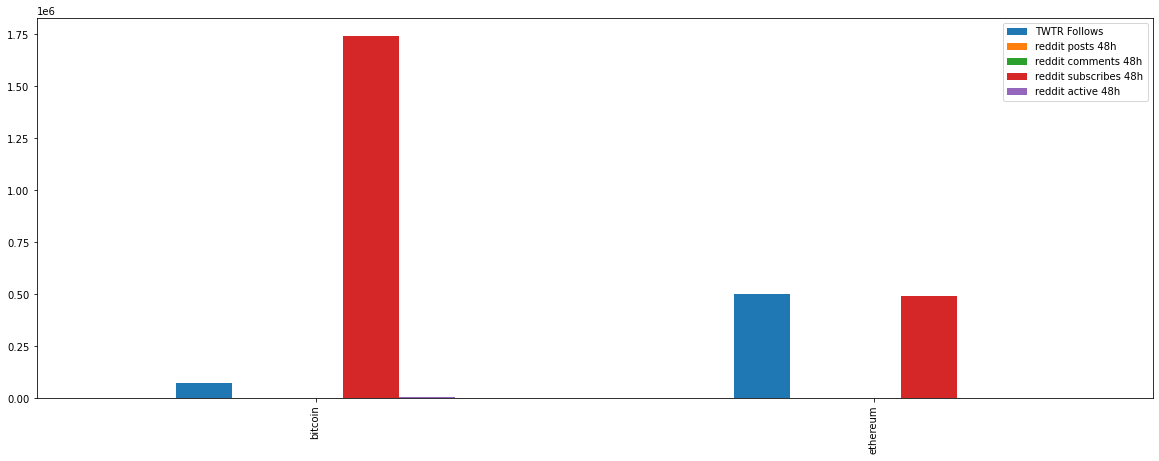

In [84]:
social_df = get_social_df(portfolio_list)

social_df.plot(kind='bar',figsize=(20,7))

In [85]:
history=get_crypt_5yr_history(portfolio_list)
history

,Ticker,Date,Price,Market Caps,Total Volumes
0,bitcoin,2015-01-01,313.992000,4.293958e+09,4.699936e+07
1,bitcoin,2015-01-02,314.446000,4.301448e+09,3.885591e+07
2,bitcoin,2015-01-03,286.572000,3.921358e+09,1.187789e+08
3,bitcoin,2015-01-04,260.936000,3.571640e+09,2.055001e+08
4,bitcoin,2015-01-05,273.220000,3.740880e+09,1.550381e+08
...,...,...,...,...,...
1911,ethereum,2020-11-01,385.844589,4.369277e+10,9.009356e+09
1912,ethereum,2020-11-02,394.936342,4.468783e+10,8.655139e+09
1913,ethereum,2020-11-03,383.849803,4.343722e+10,8.492071e+09
1914,ethereum,2020-11-04,387.616374,4.390383e+10,9.513315e+09
